Libraries

In [93]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
# import fancyimpute
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

Timer

In [94]:
warnings.simplefilter(action='ignore', category=FutureWarning)

PATH ='../../data'

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

      

kfold_lightgbm

In [99]:
def kfold_lightgbm(train_df, 
                   test_df, 
                   num_folds, 
                   stratified=False, 
                   debug=False):

    # Divide in training/validation and test data
    # train_df = df[df['TARGET'].notnull()]
    # test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM." 
          + " " + "Train shape: {}, test shape: {}"
          .format(train_df.shape, test_df.shape))
    
    #del df
    gc.collect()
    
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits=num_folds, 
                                shuffle=True, 
                                random_state=1001)
    else:
        folds = KFold(n_splits=num_folds, 
                      shuffle=True, 
                      random_state=1001)
    
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns 
             if f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000, 
            learning_rate=0.01,
            num_leaves=50,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=13, #8,
            reg_alpha=0.001, 
            reg_lambda=0.01,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, 
                eval_set=[(train_x, train_y), (valid_x, valid_y)],
                eval_metric='auc', 
                verbose=100, 
                early_stopping_rounds=200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, 
                                                 num_iteration=clf.best_iteration_)[:, 1]
        
        sub_preds += clf.predict_proba(test_df[feats], 
                                       num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
        
        test_df['TARGET'] = sub_preds

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))

    return feature_importance_df, test_df[['SK_ID_CURR', 'TARGET']]

  

dsiplay_importances

In [100]:
# Display/plot feature importance
def display_importances(feature_importance_df_, save=True):
    
    cols = feature_importance_df_[["feature", "importance"]]\
    .groupby("feature")\
    .mean()\
    .sort_values(by="importance",
                 ascending=False)[:40]\
    .index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()

    if (save):
        dt = time.time()
        plt.savefig('lgbm_importances_{0}.png'.format(dt))
        
  

data

In [102]:
def data():

    df_train = pd.read_csv('application_train.csv')
    # df = pd.read_pickle('application_ext_all.pkl')
    # df_train = df[df['TARGET'].notnull()]
    df_test = pd.read_csv('application_test.csv')
    df_test['TARGET']  = np.nan
    # del df
    
    values = [np.nan if val == 365243 else val for val in df_train['DAYS_EMPLOYED']]
    df_train['DAYS_EMPLOYED'] = values
    values = [np.nan if val == 365243 else val for val in df_test['DAYS_EMPLOYED']]
    df_test['DAYS_EMPLOYED'] = values
    
    #  train # 
    
    has_null = [col for col in df_train.columns if sum(df_train[col].isnull())]   
    has_null_num = [col for col in has_null if df_train[col].dtype == 'float']
    has_null_cat = [col for col in has_null if df_train[col].dtype == 'object']
    for col in has_null_num: 
        df_train[col] = df_train[col].fillna(df_train[col].mean())
        
    # for col in has_null_cat: df[col] = df[col].fillna('unknown_'+col)
        
    # encoding
    col_cat = [col for col in df_train.columns if df_train[col].dtype == 'object']
    for col in col_cat:
        dummy = pd.get_dummies(df_train[col], 
                               prefix=col, 
                               # drop_first=True
                              )    
        df_train = df_train.join(dummy)
        del dummy
        gc.collect()
        
    df_train = df_train.drop(col_cat, axis=1)  
    
    # X = fancyimpute.MICE().complete(df_train)
    # df_train = pd.DataFrame(X, columns=df_train.columns)
    # del X
    
    # Test #  
    
    # NULL COLUMNS
    has_null = [col for col in df_test.columns if sum(df_test[col].isnull())]
    has_null_num = [col for col in has_null if df_test[col].dtype == 'float']
    has_null_cat = [col for col in has_null if df_test[col].dtype == 'object']
    for col in has_null_num: 
        df_test[col] = df_test[col].fillna(df_test[col].mean())
    # for col in has_null_cat: df[col] = df[col].fillna('unknown_'+col)
        
    # ENCODING
    col_cat = [col for col in df_test.columns if df_test[col].dtype == 'object']
    for col in col_cat:
        dummy = pd.get_dummies(df_test[col], 
                               prefix=col, 
                               # drop_first=True
                              )    
        df_test = df_test.join(dummy)
        del dummy
        gc.collect()
        
    df_test = df_test.drop(col_cat, axis=1)
    
    # X = fancyimpute.MICE().complete(df_test)
    # df_test = pd.DataFrame(X, columns=df_test.columns)
    # del X
    
    # df_test['TARGET'] = 0
    missing_list = list(set(df_train.columns) - set(df_test.columns))
    print(missing_list)
    df_train = df_train.drop(missing_list, axis=1)
    
    #  ones = (df_train['TARGET'] == 1).sum()
    # f_0 = df_train[df_train['TARGET'] == 0].sample(ones)
    # df_train_sub = df_0.append(df_train[df_train['TARGET'] == 1])
    # del df_0
    
    ## END DM ##
    
    return df_train, df_test


main

1534062078.8891578
['CODE_GENDER_XNA', 'NAME_FAMILY_STATUS_Unknown', 'NAME_INCOME_TYPE_Maternity leave']
Starting LightGBM. Train shape: (307511, 243), test shape: (48744, 243)
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.746829	valid_1's auc: 0.73728
[200]	training's auc: 0.75985	valid_1's auc: 0.745567
[300]	training's auc: 0.770554	valid_1's auc: 0.751529
[400]	training's auc: 0.778636	valid_1's auc: 0.754963
[500]	training's auc: 0.78479	valid_1's auc: 0.756925
[600]	training's auc: 0.790238	valid_1's auc: 0.758141
[700]	training's auc: 0.795317	valid_1's auc: 0.759122
[800]	training's auc: 0.800089	valid_1's auc: 0.759618
[900]	training's auc: 0.804452	valid_1's auc: 0.759955
[1000]	training's auc: 0.808473	valid_1's auc: 0.76004
[1100]	training's auc: 0.812333	valid_1's auc: 0.760031
[1200]	training's auc: 0.816021	valid_1's auc: 0.75992
Early stopping, best iteration is:
[1058]	training's auc: 0.810755	valid_1's auc: 0.760087
Fold  1 AUC

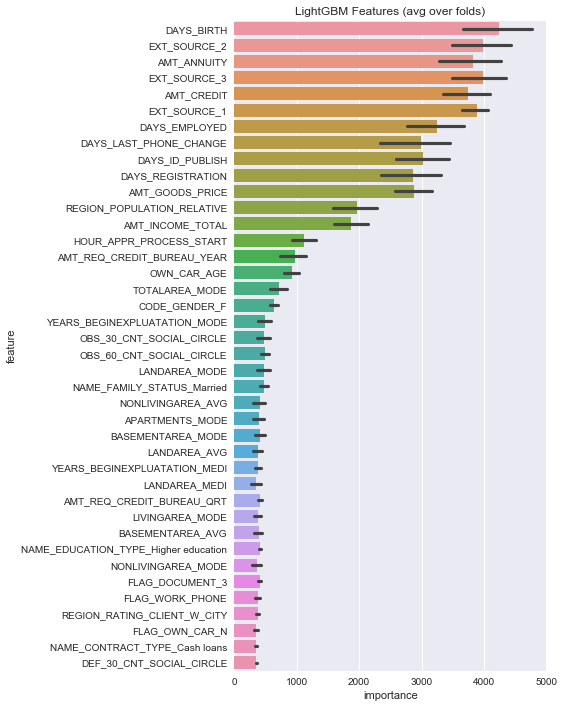

In [103]:
def main(debug=True, num_folds=2):

    df_train, df_test = data()
      
    with timer("Run LightGBM plus kfold {0}".format(num_folds)):
        feature_importance_df, test_preds = \
        kfold_lightgbm(df_train, df_test, num_folds=5, stratified=True, debug=debug)
        test_preds.to_csv('submission_{}.csv'.format(time.time()), index=False)
        display_importances(feature_importance_df)

if __name__ == "__main__":
    print("{0}".format(time.time()))
    with timer("Full model run"):
        main()

In [6]:
df = pd.read_pickle('combined_data.pkl')

In [7]:
df.to_csv('combined_data_small.csv', index=False)